In [14]:
import pandas as pd
import numpy as np
from os import walk
import pickle
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import requests
from pybt.tools.plotters import *

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [17]:
import itertools
my_array = np.linspace(0.5, 1.0, 3)
print(my_array)
repetition_number = 3
my_array = list(itertools.chain.from_iterable(itertools.repeat(x, repetition_number) for x in my_array))
print(my_array)

[0.5  0.75 1.  ]
[0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0]


In [2]:
start_path = "../quad_scan_east_slow_ions_2023_1gev/df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
filenames = sorted(filenames)
filenames

['quad_scan_east_slow_ions_2023_1GeV_2023_10_09_16h49m30s_df.pickle',
 'quad_scan_east_slow_ions_2023_1GeV_2023_10_09_17h06m57s_df.pickle']

In [3]:
# Select all measurements available
new_df = pd.DataFrame()

j = 0
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        # print(len(df))
        print(filenames[i])
    new_df = pd.concat([new_df,df])

new_df.reset_index(inplace=True)

quad_scan_east_slow_ions_2023_1GeV_2023_10_09_16h49m30s_df.pickle
quad_scan_east_slow_ions_2023_1GeV_2023_10_09_17h06m57s_df.pickle


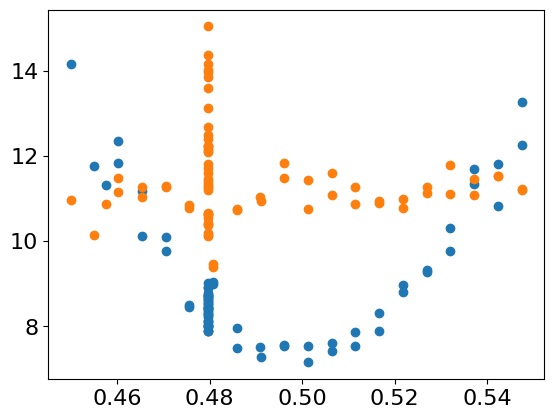

In [4]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01, new_df.sigH)
ax.scatter(new_df.k_qfn01, new_df.sigV)

# Compare with measurement

In [11]:
E_cin_per_nucleon = 1.0

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

rho = 70.0789
Brho = 3.33564 * p / charge

E_cin_proton = np.sqrt(Brho ** 2 + m_proton_GeV ** 2) - m_proton_GeV

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

print(f"Brho = {round(Brho/3.3356,3)}")

# Initial conditions
betx0 = 57.63
alfx0 = -14.358
bety0 = 3.756
alfy0 = 0.545
dx0 = 0.89
dpx0 = 0.02
dy0 = 0.687
dpy0 = 0.0
exn = 2.616e-5
eyn = 8.36e-6
sige = 0.00045

ex = exn/(beta*gamma)
# ex = 2.3e-06 # Doesn't scale with beta*gamma
ey = eyn/(beta*gamma)

Brho = 6.517


In [12]:
# Try solution

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"


H_sigma_madx_list = []
V_sigma_madx_list = []

for i in range(len(new_df)):

    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    # *[ ] add air scattering

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

Text(0.5, 0.98, 'E kinetic per nucleon  = 1.0 GeV/u')

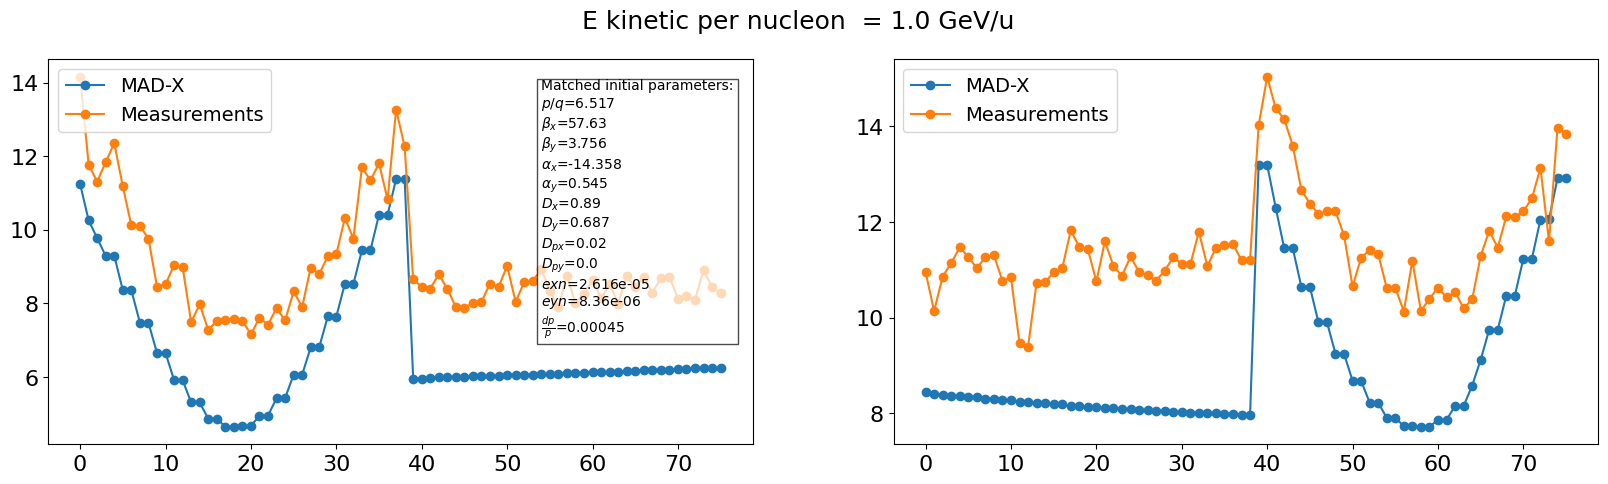

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# H
ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
ax[0].plot(new_df.sigH, marker="o", label="Measurements")

# V
ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
ax[1].plot(new_df.sigV, marker="o", label="Measurements")

ax[0].legend(loc = "upper left")
ax[1].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p/q$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
fig.suptitle(f"E kinetic per nucleon  = {E_cin_per_nucleon} GeV/u", fontsize = 18)

# Prepare optics

Text(0.5, 0.98, 'E kinetic per nucleon  = 1.0 GeV/u')

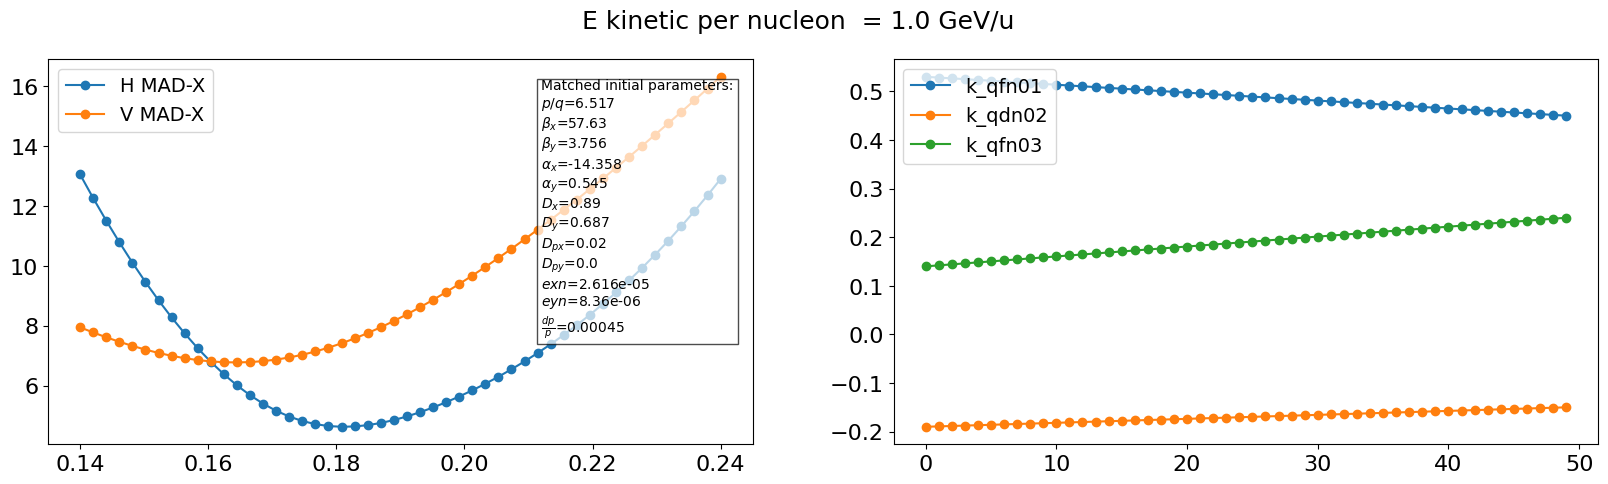

In [67]:
# Try solution

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"


H_sigma_madx_list = []
V_sigma_madx_list = []

steps = 50
k_qfn01 = np.linspace(0.53, 0.45, steps) # Init 0.47969
k_qdn02 = np.linspace(-0.19, -0.15, steps) # Init -0.1729
k_qfn03 = np.linspace(0.14, 0.24, steps) # Init 0.19864

for i in range(len(k_qfn01)):

    madx.input("kQFN1 = "+str(k_qfn01[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03[i])+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    # *[ ] add air scattering

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(k_qfn03, H_sigma_madx_list, marker="o", label="H MAD-X")
ax[0].plot(k_qfn03, V_sigma_madx_list, marker="o", label="V MAD-X")

ax[0].legend(loc = "upper left")


ax[1].plot(k_qfn01, marker="o", label="k_qfn01")
ax[1].plot(k_qdn02, marker="o", label="k_qdn02")
ax[1].plot(k_qfn03, marker="o", label="k_qfn03")
ax[1].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p/q$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
fig.suptitle(f"E kinetic per nucleon  = {E_cin_per_nucleon} GeV/u", fontsize = 18)

# Air scattering

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

def manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, L, scattering=False):
    """
    This function manipulates the global variables of a MADX instance and returns the new beta functions and emittance.
    If the scattering parameter is set to True, it also calculates the new emittance due to scattering.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    exn (float): The normalized horizontal emittance.
    eyn (float): The normalized vertical emittance.
    p (float): The momentum of the beam.
    beta (float): The relativistic beta factor.
    gamma (float): The relativistic gamma factor.
    L (float): The length of the air region.
    scattering (bool): A boolean indicating whether to calculate the new emittance due to scattering.

    Returns:
    betx0 (float): The new horizontal beta function.
    bety0 (float): The new vertical beta function.
    alfx0 (float): The new horizontal alpha function.
    alfy0 (float): The new vertical alpha function.
    dx0 (float): The new horizontal dispersion.
    dy0 (float): The new vertical dispersion.
    dpx0 (float): The new horizontal momentum deviation.
    dpy0 (float): The new vertical momentum deviation.
    exn (float): The new horizontal emittance.
    eyn (float): The new vertical emittance.
    """

    madx.globals['betx0'] = 'savebeta_air->betx'
    madx.globals['bety0'] = 'savebeta_air->bety'
    madx.globals['alfx0'] = 'savebeta_air->alfx'
    madx.globals['alfy0'] = 'savebeta_air->alfy'
    madx.globals['dx0'] = 'savebeta_air->dx'
    madx.globals['dy0'] = 'savebeta_air->dy'
    madx.globals['dpx0'] = 'savebeta_air->dpx'
    madx.globals['dpy0'] = 'savebeta_air->dpy'

    if scattering==True:
        
        epsilon_0 = exn/(beta*gamma)
        epsilon_0_V = eyn/(beta*gamma)

        p_MeV = p*1000 # Beam total energy in MeV
        q = 1
        P = 1.01325 # Standard air pressure at sea level in Bar
        P_Torr = P*750.062 # Standard air pressure at sea level in Torr
        L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
        L_rad = L_rad0/(P_Torr/760)

        theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

        # Horizontal
        gamma0 = (1 + madx.globals['alfx0']**2) / madx.globals['betx0']
        Delta_epsilon = (1/2)*theta_rms**2*(madx.globals['betx0'] + L*madx.globals['alfx0'] + (L**2/3)*gamma0)
        epsilon_1 = epsilon_0 + Delta_epsilon
        alfx0_1 = (epsilon_0*madx.globals['alfx0'] - (L/2)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)
        betx0_1 = (epsilon_0*madx.globals['betx0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)

        # Vertical
        gamma0_V = (1 + madx.globals['alfy0']**2) / madx.globals['bety0']
        Delta_epsilon_V = (1/2)*theta_rms**2*(madx.globals['bety0'] + L*madx.globals['alfy0'] + (L**2/3)*gamma0_V)
        epsilon_1_V = epsilon_0_V + Delta_epsilon_V
        alfy0_1 = (epsilon_0_V*madx.globals['alfy0'] - (L/2)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)
        bety0_1 = (epsilon_0_V*madx.globals['bety0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)

        # Return
        exn = epsilon_1*beta*gamma
        eyn = epsilon_1_V*beta*gamma
        betx0 = betx0_1
        alfx0 = alfx0_1
        bety0 = bety0_1
        alfy0 = alfy0_1
        
    else:
        betx0 = madx.globals['betx0']
        alfx0 = madx.globals['alfx0']
        bety0 = madx.globals['bety0']
        alfy0 = madx.globals['alfy0']
    
    dx0 = madx.globals['dx0']
    dy0 = madx.globals['dy0']
    dpx0 = madx.globals['dpx0']
    dpy0 = madx.globals['dpy0']

    return betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn

def add_air_region(madx, title, sequence, air_start_pos, air_stop_pos, steps):
    """
    This function adds an air region to the MADX sequence.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    air_start_pos (float): The starting position of the air region.
    air_stop_pos (float): The stopping position of the air region.
    steps (float): The distance between two consecutive inner markers.

    Returns:
    None
    """

    # Calculate the positions of the inner markers
    inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

    # Add the markers for the start and end of the air region
    madx.input(f'''
    AIR_START : MARKER;
    AIR_END : MARKER;
    ''')           

    # Install the markers for the start and end of the air region
    madx.input(f'''
    SEQEDIT, SEQUENCE={sequence};
    INSTALL, ELEMENT=AIR_START, CLASS=AIR_START, AT={air_start_pos};
    INSTALL, ELEMENT=AIR_END, CLASS=AIR_END, AT={air_stop_pos};
    ENDEDIT;
    ''')

    # Add the inner markers
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    # Create a for loop for the inner markers:
    for count, pos in enumerate(inner_marker_array):
        madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}_{title}, CLASS=MARKER, AT={pos};")
        # print(f"INNER_MARKER{str(count)}")
    madx.input("ENDEDIT;")

    return

def add_hidden_marker(madx, sequence, start, stop, steps):
    # Add marker at the end of the line to see the evolution of the beam with fine resolution
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    for count, pos in enumerate(np.arange(start, stop, steps)):
        madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
    madx.input("ENDEDIT;")

    return

def process_scattering(madx, exn, eyn, beta, gamma, sequence, end, p, twiss_initial, ex_initial, ey_initial):

    air_start_elements = [name for name in twiss_initial.name if "air_start" in name]
    # print(f"There are {len(air_start_elements)} air regions in the sequence: {air_start_elements}")

    air_start_numbers = [int(name.split(':')[1]) for name in air_start_elements]
    # print(f"The air regions are numbered: {air_start_numbers}")

    inner_elements = [name for name in twiss_initial.name if "inner" in name]

    def update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list):
        madx.command.beam(ex=exn/(beta*gamma), ey=eyn/(beta*gamma))
        ex_list.append(madx.sequence[sequence].beam.ex)
        ey_list.append(madx.sequence[sequence].beam.ey)
        return madx, ex_list, ey_list

    def append_twiss_to_list(madx, sequence, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0):
        madx.use(sequence=sequence)
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
        twiss_list.append(twiss)
        return twiss_list

    twiss_list = []
    ex_list = []
    ey_list = []

    betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=False, L=0)

    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    madx.input(f"EXTRACT, SEQUENCE = {sequence}, FROM=AIR_START, TO={end}, NEWNAME=seq_air_start_to_end;")
    madx.input("ENDEDIT;")

    previous_seq_name = "seq_air_start_to_end"

    # Iterating over all air regions
    for air_region_number in air_start_numbers:
        # print(f"Entering air region {air_region_number}")

        if air_region_number == 1:
            air_start_pos = madx.sequence[sequence].elements["air_start"].position

        else:
            air_start_pos = madx.sequence[sequence].elements[f"air_start[{str(air_region_number)}]"].position

        # print(air_start_pos)

        inner_marker_list = [name for name in inner_elements if name.endswith(f"{air_region_number}:1")]
        for i in range(len(inner_marker_list)):

            if i == 0:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - air_start_pos
            else:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - madx.sequence[sequence].elements[inner_marker_list[i-1][:-2]].position

            madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

            # print(f"SAVEBETA at INNER_MARKER{str(i)}_{str(air_region_number)}")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER{str(i)}_{str(air_region_number)}, SEQUENCE={previous_seq_name};")
            twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)

            # print(f"Extracting from INNER_MARKER{str(i)}_{str(air_region_number)} to {end}")
            madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=INNER_MARKER{str(i)}_{str(air_region_number)}, TO={end}, NEWNAME=seq_inner_marker{str(i)}_to_end;")
            madx.input("ENDEDIT;")

            previous_seq_name = f"seq_inner_marker{str(i)}_to_end"
        
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

        #### Air_END ####
        # Final step calculation
        if air_region_number == 1:
            air_end_pos = madx.sequence[sequence].elements["air_end"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position
        else:
            air_end_pos = madx.sequence[sequence].elements[f"air_end[{str(air_region_number)}]"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position

        # print(f"SAVEBETA at AIR_END")
        if air_region_number == 0:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END, SEQUENCE={previous_seq_name};")
        else:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END[{str(air_region_number)}], SEQUENCE={previous_seq_name};")

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)
        
        madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
        if air_region_number == 1:
            # print(f"Extracting from AIR_END to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end_to_end;")
        else:
            # print(f"Extracting from AIR_END[{str(air_region_number)}] to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end{str(air_region_number)}_to_end;")
        madx.input("ENDEDIT;")

        
        if air_region_number == 1:
            previous_seq_name = f"seq_air_end_to_end"
        else:
            previous_seq_name = f"seq_air_end{str(air_region_number)}_to_end"

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)


    # Shift the s position so that is is coherent.
    for i in range(len(twiss_list)):
        twiss_list[i].s = twiss_list[i].s + twiss_initial.loc[twiss_list[i].iloc[1].name].s


    # We add the emittances to each twiss table
    twiss_initial['ex'] = ex_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ex'] = ex_list[i]

    twiss_initial['ey'] = ey_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ey'] = ey_list[i]

    # We remove the drifts as they are duplicated names
    def remove_drift_rows(df):
        df = df.loc[~df.index.str.startswith('drift')]
        df = df.loc[~df.index.str.startswith('#s')]
        return df

    twiss_list = [remove_drift_rows(df) for df in twiss_list]

    # We combine all the twiss tables into one
    def add_missing_rows(df1, df2):
        # Find rows in df1 with lower 's' than the minimum 's' in df2
        missing_rows = df1[df1['s'] < df2['s'].min()]
        
        # Append these rows to df2 and sort by 's'
        df2_updated = pd.concat([df2, missing_rows]).sort_values(by='s')

        return df2_updated

    # Loop through each element in the list
    for i in range(1, len(twiss_list)):
        twiss_list[i] = add_missing_rows(twiss_list[i-1], twiss_list[i])

    # Finaly, we add the initial twiss table to the beginning
    twiss_scattered = add_missing_rows(twiss_initial, twiss_list[-1])

    return twiss_initial, twiss_scattered

100%|██████████| 65/65 [00:49<00:00,  1.31it/s]


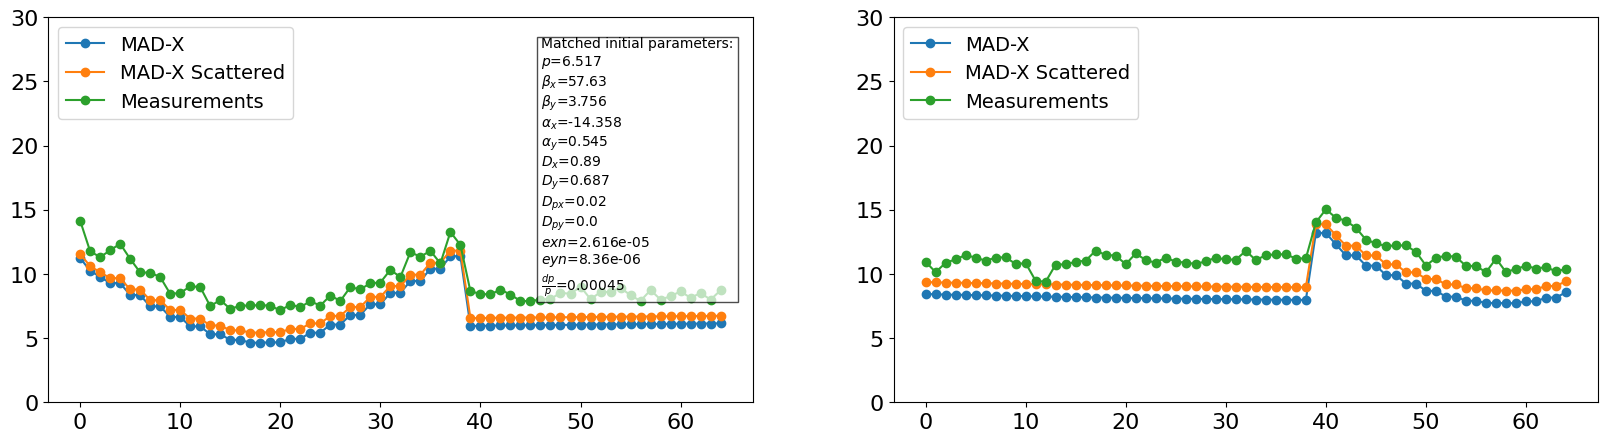

In [69]:
ex_initial = ex
ey_initial = ey

from tqdm import tqdm

fig, ax = plt.subplots(1,2, figsize=(20, 5))

H_sigma_madx_list = []
V_sigma_madx_list = []
H_sigma_madx_list_scattered = []
V_sigma_madx_list_scattered = []

for item in tqdm(new_df.iterrows(), total=len(new_df)):
    
    i = item[0]

    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
    madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
    madx.use(sequence="f61d")

    btv="f61.btv010"

    # Add the Air region
    sequence = "f61d"

    p1 = madx.sequence['f61d'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
    p2 = madx.sequence['f61d'].elements["f61.btv012"].position
    add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61d'].elements["f61.bctf022"].position
    p2 = madx.sequence['f61d'].elements["f61.mbxhd025"].position + madx.sequence['f61d'].elements["f61.mbxhd025"].length + 0.3
    add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

    madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
    madx.use(sequence="f61d")

    # make thin
    madx.use(sequence="f61d")
    madx.input('SEQEDIT, sequence=f61d;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence="f61d")
    madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
    # madx.input("MAKETHIN, SEQUENCE=f61d, style=TEAPOT")
    madx.use(sequence="f61d")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "f61.end", p/charge, twiss, ex_initial, ey_initial)

    H_sigma_madx = ( beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_scattered = ( beam_size(twiss_scattered['betx'][btv], twiss_scattered['dx'][btv], twiss_scattered['ex'][btv], sige, 1) )*1000
    V_sigma_madx_scattered = ( beam_size(twiss_scattered['bety'][btv], twiss_scattered['dy'][btv], twiss_scattered['ey'][btv], sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

    H_sigma_madx_list_scattered.append(H_sigma_madx_scattered)
    V_sigma_madx_list_scattered.append(V_sigma_madx_scattered)


ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
ax[0].plot(H_sigma_madx_list_scattered, marker="o", label="MAD-X Scattered")
ax[0].plot(new_df.sigH, marker="o", label="Measurements")

ax[0].set_ylim(0,30)
ax[0].legend(loc="upper left")

ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
ax[1].plot(V_sigma_madx_list_scattered, marker="o", label="MAD-X Scattered")
ax[1].plot(new_df.sigV, marker="o", label="Measurements")

ax[1].set_ylim(0,30)
ax[1].legend(loc="upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()